In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import os
import re
import netCDF4 as nc

from sqlalchemy.sql import select, and_, or_, not_, func
from sqlalchemy import create_engine, Column, String, Integer, Boolean, MetaData, Table, case, between, ForeignKey
from sqlalchemy.orm import mapper, create_session, relationship
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.ext.automap import automap_base
import sqlalchemy.types as types
from sqlalchemy.sql import select, and_, or_, not_, func
from time import strptime
import string
import pandas as pd
from dateutil.parser import parse as dutparse
#from dataProcess import forceNumeric, forceInt, fmtVarName, data2Tbl, adFunONC

%matplotlib inline

In [2]:
basepath='/ocean/eolson/MEOPAR/obs/'
basedir=basepath + 'ECBuoy/'
dbname='ECBuoy'
Base = automap_base()
engine = create_engine('sqlite:///' + basedir + dbname + '.sqlite', echo = False)
# reflect the tables in salish.sqlite:
Base.prepare(engine, reflect=True)
# mapped classes have been created
FBuoyTBL=Base.classes.FBuoyTBL
FlowTBL=Base.classes.FlowTBL
session = create_session(bind = engine, autocommit = False, autoflush = True)

In [3]:
dfF0=pd.read_csv('/ocean/eolson/MEOPAR/obs/ECRivers/Flow/FraserHopeDaily__Dec-2-2020_10_31_05PM.csv',skiprows=1)
dfF=dfF0.loc[(dfF0.PARAM==1)&(dfF0.YEAR>2008)].copy(deep=True).reset_index()

In [4]:
dfF.tail()

,index,ID,PARAM,YEAR,DD,Value,SYM
3646,39016,08MF005,1,2018,360,1090.0,NaN
3647,39017,08MF005,1,2018,361,1050.0,NaN
3648,39018,08MF005,1,2018,362,1030.0,NaN
3649,39019,08MF005,1,2018,363,1120.0,NaN
3650,39020,08MF005,1,2018,364,1170.0,NaN


In [5]:
dfF['dtUTC']=[dt.datetime(yr,1,1)+dt.timedelta(days=dd) for yr,dd in zip(dfF['YEAR'],dfF['DD'])]

In [6]:
df=pd.DataFrame(session.query(FBuoyTBL.DecDay,FBuoyTBL.Turb_NTU).filter(
            FBuoyTBL.Turb_NTU.between(0,400)).all()) # filter out negative and isolated instances of really large numbers

In [7]:
df['dtUTC']=[dt.datetime(1900,1,1)+dt.timedelta(days=ii) for ii in df['DecDay']]

/home/eolson/anaconda3/envs/py38_ct/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Flow (m$^3$/s)')

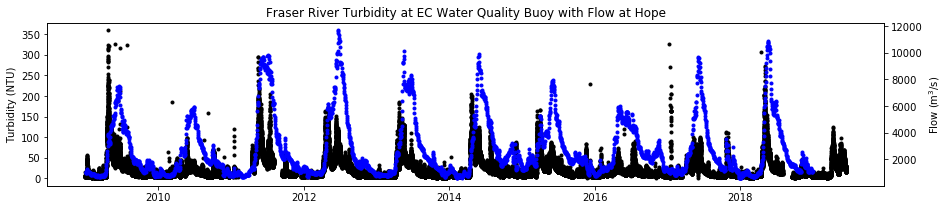

In [8]:
fig,ax=plt.subplots(1,1,figsize=(15,3))
ax2=ax.twinx()
ax.plot(df['dtUTC'],df['Turb_NTU'],'k.')
ax.set_ylabel('Turbidity (NTU)')
ax.set_title('Fraser River Turbidity at EC Water Quality Buoy with Flow at Hope')
ax2.plot(dfF['dtUTC'],dfF['Value'],'b.')
ax2.set_ylabel('Flow (m$^3$/s)')

### Break down by year

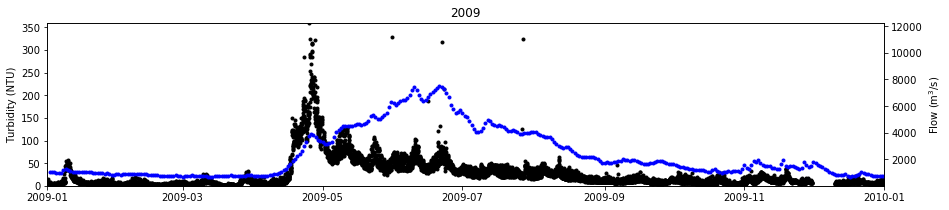

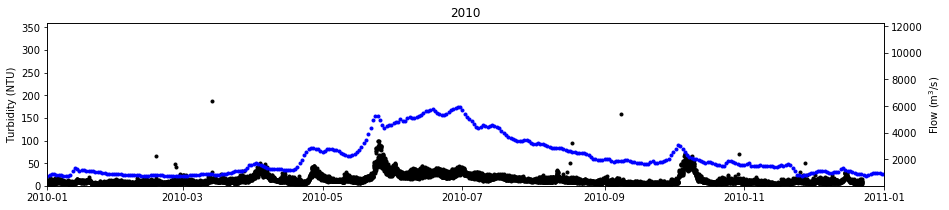

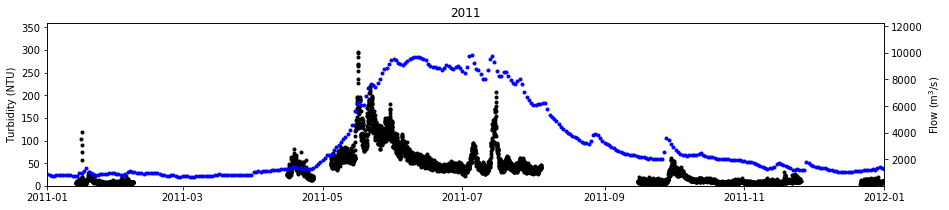

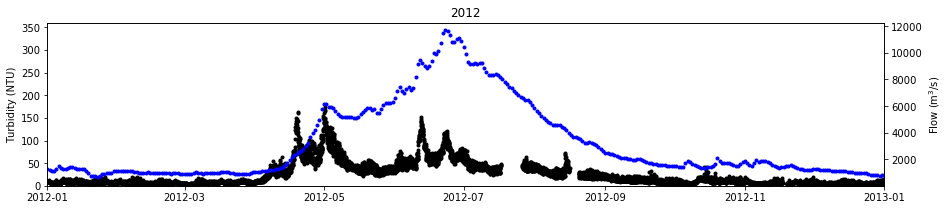

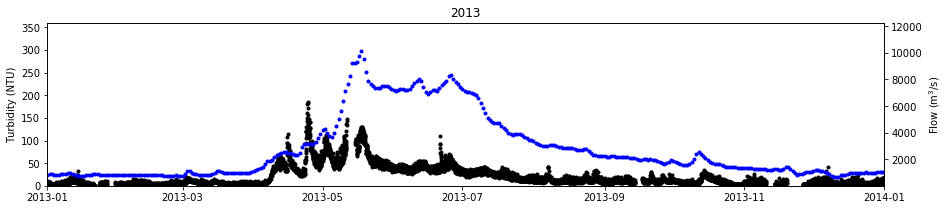

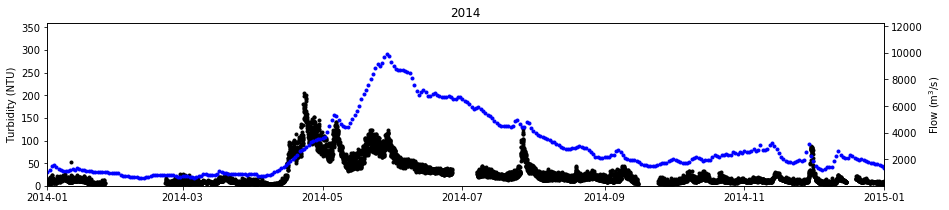

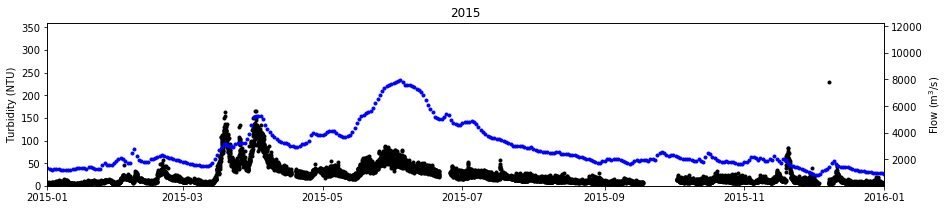

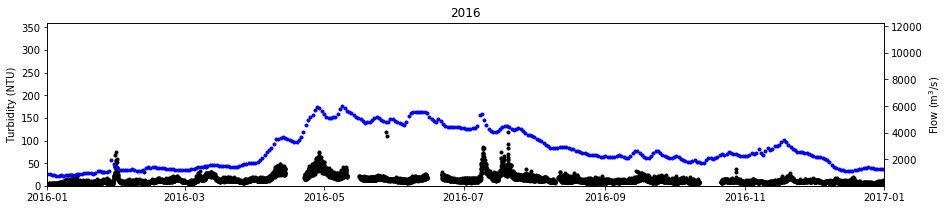

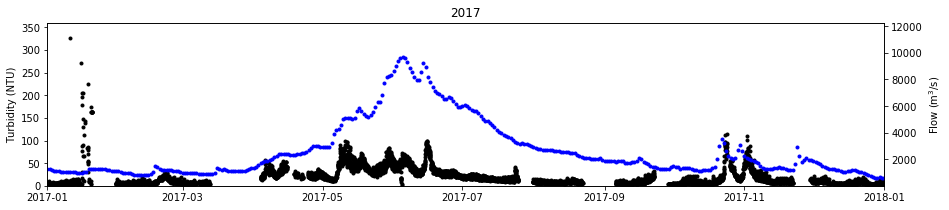

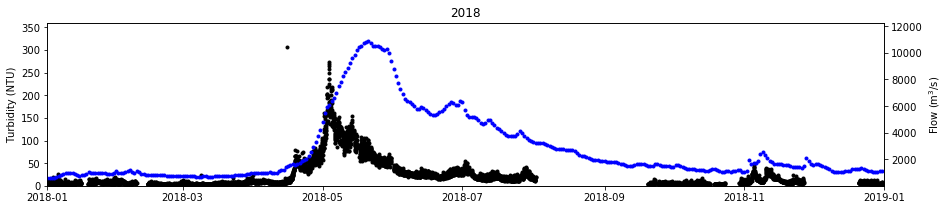

In [9]:
for year in range(2009,2019):
    df2=df.loc[(df.dtUTC>=dt.datetime(year,1,1))&(df.dtUTC<dt.datetime(year+1,1,1))]
    fig,ax=plt.subplots(1,1,figsize=(15,3))
    ax2=ax.twinx()
    ax.plot(df2['dtUTC'],df2['Turb_NTU'],'k.')
    ax.set_ylabel('Turbidity (NTU)')
    ax.set_title(year)
    ax.set_xlim(dt.datetime(year,1,1),dt.datetime(year+1,1,1))
    ax.set_ylim(0,360)
    ax2.plot(dfF['dtUTC'],dfF['Value'],'b.')
    ax2.set_ylabel('Flow (m$^3$/s)')

In [10]:
session.close()
engine.dispose()